In [ ]:
# ! git clone https://github.com/icey6Lulu/VisualFeatureSearch.git
# ! pip install torch
# ! pip install torchvision
# ! pip install zarr
# ! pip install torchsummary
# ! pip install opencv-python


In [1]:
import torch
from torchvision import transforms, utils

IMAGENET_MU = [0.485, 0.456, 0.406]
IMAGENET_SIGMA = [0.229, 0.224, 0.225]


class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super(NormalizeInverse, self).__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super(NormalizeInverse, self).__call__(tensor.clone())


class Clip(object):
    """Pytorch transformation that clips a tensor to be within [0,1]"""
    def __init__(self):
        return

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): tensor to be clipped.
        Returns:
            Tensor: clipped tensor.
        """
        t = tensor.clone()
        t[t > 1] = 1
        t[t < 0] = 0
        return t
def get_detransform(mu=IMAGENET_MU, sigma=IMAGENET_SIGMA):
    detransform = transforms.Compose([
        NormalizeInverse(mu, sigma),
        Clip(),
        # transforms.ToPILImage(),
    ])
    return detransform

detransform = get_detransform()

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

87
Image name and label: ILSVRC2012_val_00000088.JPEG 28
Image name: ILSVRC2012_val_00000088.JPEG
Image label:28
Documents/GitHub/val_250/val_250/ILSVRC2012_val_00000088.JPEG
Image classification:  'spotted salamander, Ambystoma maculatum'
Image label:28


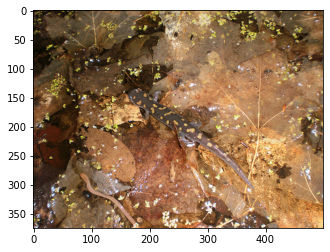

Image type: torch.FloatTensor
Image size: torch.Size([3, 375, 500])


In [3]:
import pandas as pd
import random
from PIL import Image

dataset250 = pd.read_csv('Documents/GitHub/val_250/path_lable.txt', sep = '/', header = None, names = ["path", "label"])
n = random.randint(0, 250)
print(n)
img_name_label = dataset250.iloc[n, 1]

print('Image name and label: {}'.format(img_name_label))
path, label_str = img_name_label.split()
label = int(label_str)
print('Image name: {}'.format(path))
print('Image label:{}'.format(label))

gdr_path = "Documents/GitHub/val_250/val_250/"

img_path = gdr_path+path
print(img_path)

lable_name = pd.read_csv('Documents/GitHub/val_250/lables.txt', sep = ':')
class_names = []
for i in range(1000):
  class_names.append(lable_name.iloc[i-1, 1].rstrip(","))

print('Image classification: {}'.format(class_names[label]))
print('Image label:{}'.format(label))

# function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file.
image = Image.open(img_path)
rgb_image = pil2tensor(image)

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))


In [16]:
import sys
sys.path.append('./VisualFeatureSearch')
from vissearch import widgets, util, data
convert_tensor = transforms.ToTensor()

size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # (x - mean) / std
])

# x = convert_tensor(image)

x = transform(image)

query_vis_transform = transforms.Compose([
    transforms.CenterCrop((256,256)),
    transforms.Resize((224,224))
])

query_model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# query_imgs = [load_img(id) for id in query_img_ids]
query_img = query_vis_transform(image)
# convert images to Data URLs so we can pass them into the HTML widget
query_img_url = util.image_to_durl(query_img)

# print(query_img_url)
highlight_data = None
mask = None
#highlight_index = None
def highlight_callback(data):
    global highlight_data 
    print(highlight_data)
    highlight_data = data
    global mask
    mask = util.durl_to_image(data)
    mask_arr = np.asarray(mask)[:,:,3] / 256 # take just the alpha channel

    curr_mask_overlay = util.mask_overlay(query_img, x=0, y=0, mask_size=224, mask=mask_arr, alpha=0.5, beta=0.4)

    fig = plt.figure(figsize=(10, 3))

    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(query_img, cmap='gray')

    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(mask_arr, cmap='gray')

    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(curr_mask_overlay)
    
    
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    model.eval()

    img_input = img_transform(query_img)
    mask_input = mask_transform(mask_arr)
    data_out = score_gen(transform_Gaussian, img_input, mask_input, model)
    df = pd.DataFrame(data_out, columns=['Class', 'Confidence'])
    print(df)
    os.makedirs('Documents/GitHub', exist_ok=True)  
    df.to_csv('Documents/GitHub/out.csv')  

    #ploting the chart non-interactively
    X = list(df.iloc[:, 0])
    Y = list(df.iloc[:, 1])
  
    # Plot the data using bar() method
    plt.barh(X, Y, color='b')
    plt.title("Results")
    plt.xlabel("Class")
    plt.ylabel("Confidence")
  
    # Show the plot
    plt.show()


util.create_callback('highlight_callback', highlight_callback)
widgets.HighlightWidget(query_img_url, callback_name='highlight_callback')


In [ ]:
# Change the callback function: 
#     1. move all of the below functions into the callback function
#     2. move everything unrelated to highlight into a library and call it directly
#     3. once lifting the mouse, the callback function should have gone through the process and output the desired data
    
# Progressing steps:
#     1. Play around with html and change the html widget, output rectangle etc.
#     2. change the call back function



<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=224x224 at 0x7FB4750AC0A0>

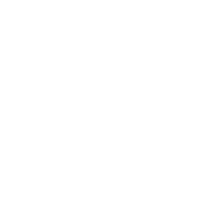

In [17]:
print(highlight_data)
print(mask)

In [ ]:
import numpy as np
print(highlight_data)

mask = util.durl_to_image(highlight_data)
mask_arr = np.asarray(mask)[:,:,3] / 256 # take just the alpha channel

curr_mask_overlay = util.mask_overlay(query_img, x=0, y=0, mask_size=224, mask=mask_arr, alpha=0.5, beta=0.4)

fig = plt.figure(figsize=(10, 3))

plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(query_img, cmap='gray')

plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mask_arr, cmap='gray')

plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(curr_mask_overlay)

In [ ]:
import torch.nn as nn
def mask_transform(mask_input):
  mask_3d = mask_input.reshape(1, 224, 224)
  msk = torch.from_numpy(mask_3d).float()
  return msk

def img_transform(img_input):
  tensor_trans = transforms.ToTensor()
  img_tensor = tensor_trans(img_input)
  img = img_tensor.float()
  return img

def transform_preservation (img_input, mask_input):
  masked_img = mask_input * img_input
  return masked_img

def transform_deletion(img_input, mask_input):
  masked_img = (1-mask_input) * img_input
  return masked_img

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform_g=transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.ToTensor(),
                              AddGaussianNoise(0.15, 0.2)  
                           ])

def transform_Gaussian(img_input, mask_input):
  blur_part = mask_input * img_input
  masked_img = img_input * (1-mask_input) + mask_input * transform_g(blur_part)
  return masked_img

import torchvision.transforms as T
transform_n = T.GaussianBlur(kernel_size=(17, 17), sigma=(0.1, 200))

def transform_Noise(img_input, mask_input):
  blur_part = mask_input * img_input
  masked_img = img_input * (1-mask_input) + mask_input * transform_n(blur_part)
  return masked_img

def score_gen (transform, img_input, mask_input, model):

  masked_img = transform(img_input, mask_input)
  plot_image(masked_img)

  # put through model
  with torch.no_grad():
    y_output = model(masked_img.unsqueeze(0))
  
  softmax = nn.Softmax()
  y_softmax = softmax(y_output)
  k = 5

  confidences = np.squeeze(y_output)
  inds = np.argsort(-confidences)
  top_k = inds[:k]
  data_csv = []

  print(f'Correct Prediction: {class_names[label]}')
  print('Preservation Model:')
  for i, ind in enumerate(top_k):
    data_csv.append([class_names[ind], 100*y_softmax[0,ind].item()])
    print(f'Class #{i + 1} - {class_names[ind]} - Logit: {y_output[0,ind]:.2f} - Softmax: {100*y_softmax[0,ind]:.2f}%')
  return data_csv

In [ ]:
import os

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

img_input = img_transform(query_img)
mask_input = mask_transform(mask_arr)
data_out = score_gen(transform_Gaussian, img_input, mask_input, model)
df = pd.DataFrame(data_out, columns=['Class', 'Confidence'])
print(df)
os.makedirs('Documents/GitHub', exist_ok=True)  
df.to_csv('Documents/GitHub/out.csv')  

#ploting the chart non-interactively
X = list(df.iloc[:, 0])
Y = list(df.iloc[:, 1])
  
# Plot the data using bar() method
plt.barh(X, Y, color='b')
plt.title("Results")
plt.xlabel("Class")
plt.ylabel("Confidence")
  
# Show the plot
plt.show()

In [ ]:
from IPython.display import HTML
HTML(filename='Documents/Barchart/Barchart.html')